In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline

### Camera calibration

In [2]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
    else:
        print("%s failed\n" % fname)

cv2.destroyAllWindows()

camera_cal/calibration4.jpg failed

camera_cal/calibration5.jpg failed

camera_cal/calibration1.jpg failed



### Distortion correction

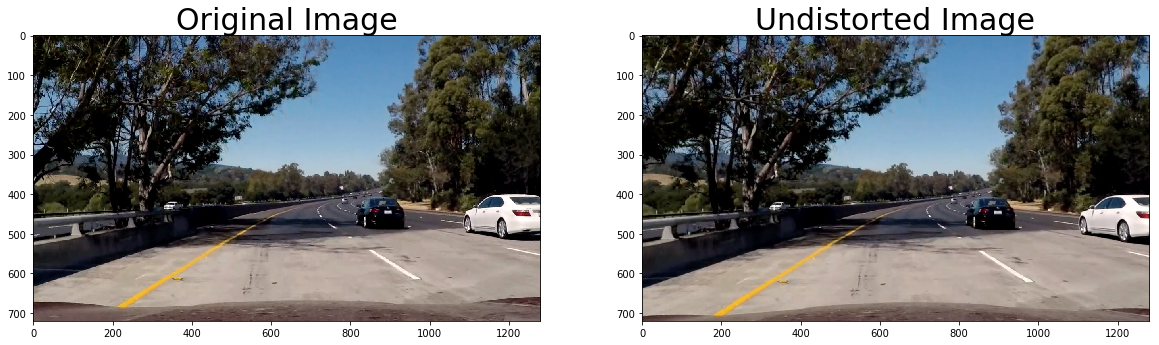

In [3]:
# Test undistortion on an image
img = cv2.imread('test_images/test5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

img_undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

### Create a thresholded binary image

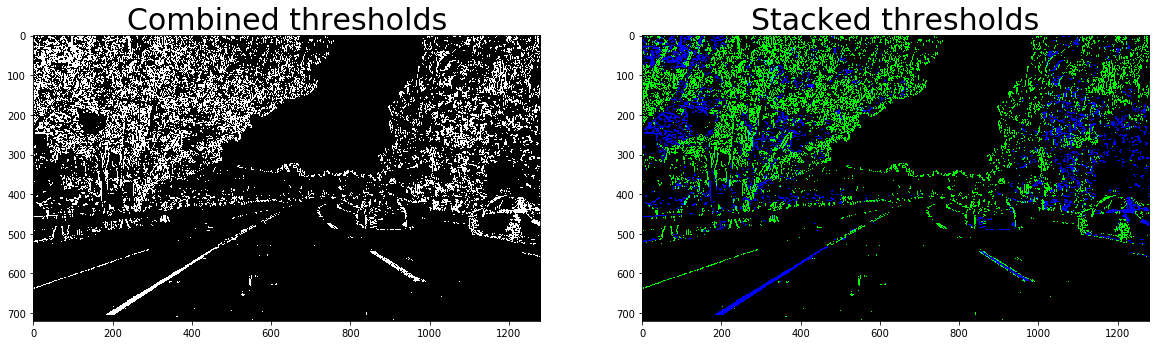

In [4]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100), h_thresh=100):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (h_channel<h_thresh)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #color_binary = np.dstack(( np.zeros_like(sxbinary), np.zeros_like(sxbinary), s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

color_binary, combined_binary = threshold(img_undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Combined thresholds', fontsize=30)
ax1.imshow(combined_binary, cmap='gray')

ax2.imshow(color_binary)
ax2.set_title('Stacked thresholds', fontsize=30)


### Perspective transform

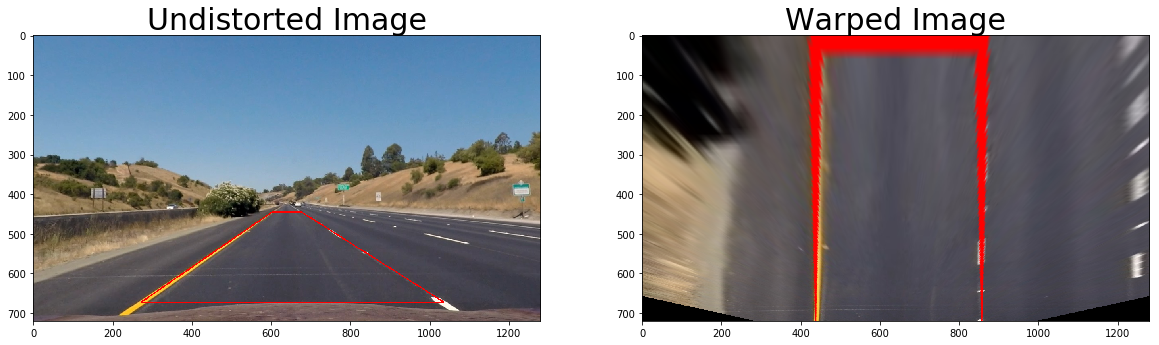

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
cal_img = cv2.imread('test_images/straight_lines1.jpg')
cal_img_size = (cal_img.shape[1], cal_img.shape[0])
cal_img_undist = cv2.cvtColor(cv2.undistort(cal_img, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB)

verta = np.array([[[272,672,602,445],[602,445,676,445],[676,445,1035,672],[1035,672,272,672]]], dtype=np.int32)
draw_lines(cal_img_undist, verta, color=[255,0,0], thickness=2)    

# source points
src = np.float32([[272,672],[602,445],[676,445],[1035,672]])

# destination points
dst = np.float32([[(src[0][0]+src[1][0])/2, cal_img.shape[0]],[(src[0][0]+src[1][0])/2,0],[(src[2][0]+src[3][0])/2,0],[(src[2][0]+src[3][0])/2, cal_img.shape[0]]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(cal_img_undist, M, (cal_img.shape[1],cal_img.shape[0]))     

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cal_img_undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)


### Adding a mask

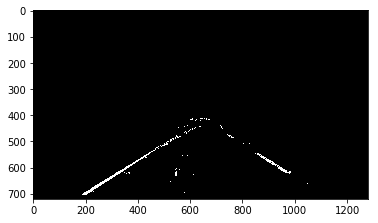

In [6]:
mask = np.zeros_like(combined_binary)    
imshape = mask.shape
vertices = np.array([[(100,imshape[0]),(imshape[1]/2-10, 400), (imshape[1]/2+10, 400), (imshape[1]-100,imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, 1) 
plt.imshow(combined_binary*mask, cmap='gray')

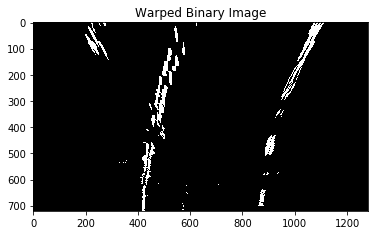

In [7]:
binary_warped = cv2.warpPerspective(combined_binary*mask, M, (combined_binary.shape[1],combined_binary.shape[0]))     
plt.figure()
ax = plt.subplot()
plt.imshow(binary_warped, cmap='gray')
ax.set_title('Warped Binary Image')


### Detect lane pixels and find the lane boundary

In [8]:
def getLanePixels(binary_warped, margin=100, nwindows=9):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/3):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzero


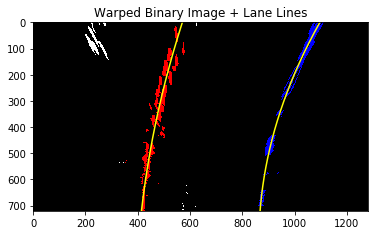

In [9]:
left_lane_inds, right_lane_inds, nonzero = getLanePixels(binary_warped, margin=80) 

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure()
ax = plt.subplot()
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim([720,0])
ax.set_title('Warped Binary Image + Lane Lines')


### Radius of curvature of the lane

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/((src[2][0]+src[3][0])/2-(src[0][0]+src[1][0])/2) # meters per pixel in x dimension
fac1 = xm_per_pix/ym_per_pix  # for dx/dy
fac2 = xm_per_pix/ym_per_pix**2 # for dx^2/dy^2 

#evalute the curvature close to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (fac1*(2*left_fit[0]*y_eval + left_fit[1]))**2)**1.5) / np.absolute(2*fac2*left_fit[0])
right_curverad = ((1 + (fac1*(2*right_fit[0]*y_eval + right_fit[1]))**2)**1.5) / np.absolute(2*fac2*right_fit[0])
print('left curvature: %.0f m' % left_curverad)
print('right curvature: %.0f m' % right_curverad)

left curvature: 683 m
right curvature: 294 m


### Vehicle position with respect to the center of the lane

In [11]:
veh_pos = binary_warped.shape[1]/2
lane_center = (left_fitx[-1]+right_fitx[-1])/2
veh_pos_rel = veh_pos - lane_center
print('vehicle position: %.1f pixel (%.3f m)' % (veh_pos_rel,veh_pos_rel*xm_per_pix))

vehicle position: -1.3 pixel (-0.011 m)


### Warp the detected lane boundaries back onto the original image after distortion correction

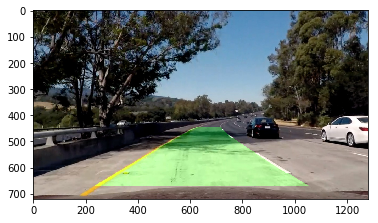

In [12]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)
plt.imshow(result)

### Pipeline to process the video

In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


In [14]:
leftLine = Line()
rightLine = Line()
usePrevious = False
midY = np.mean(ploty) # to evaluate curvature

In [15]:
def process_image(img):
    # correct distortion
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # threshold binary image
    s_thresh=(80, 255)
    sx_thresh=(20, 100)
    h_thresh=100
    hls = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (h_channel<h_thresh)] = 1        
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1))] = 1  
    
    binary_warped = cv2.warpPerspective(combined_binary*mask, M, (combined_binary.shape[1],combined_binary.shape[0]))     

    # find lane pixels
    if usePrevious and leftLine.detected and rightLine.detected:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        leftBound = leftLine.fit[0]*(nonzeroy**2) + leftLine.fit[1]*nonzeroy + leftLine.fit[2]
        rightBound = rightLine.fit[0]*(nonzeroy**2) + rightLine.fit[1]*nonzeroy + rightLine.fit[2]
        left_lane_inds = ((nonzerox > (leftBound - margin)) & (nonzerox < (leftBound + margin))) 
        right_lane_inds = ((nonzerox > (rightBound - margin)) & (nonzerox < (rightBound + margin)))  
    else:
        left_lane_inds, right_lane_inds, nonzero = getLanePixels(binary_warped, margin=80)
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1]) 
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #curvature
    left_curverad = ((1 + (fac1*(2*left_fit[0]*midY + left_fit[1]))**2)**1.5) / np.absolute(2*fac2*left_fit[0])
    right_curverad = ((1 + (fac1*(2*right_fit[0]*midY + right_fit[1]))**2)**1.5) / np.absolute(2*fac2*right_fit[0])
    
    if usePrevious:
        curvDiff = min(left_curverad,right_curverad)/max(left_curverad,right_curverad)
        if curvDiff > 0.1:
            leftLine.detected = True
            rightLine.detected = True
            leftLine.fit = left_fit
            rightLine.fit = right_fit
            leftLine.radius_of_curvature = left_curverad
            rightLine.radius_of_curvature = right_curverad
        else:
            leftLine.detected = False
            rightLine.detected = False
            left_fit = leftLine.fit
            right_fit = rightLine.fit
            print('left curvature: %.0f m %.4f' % (left_curverad,left_fit[0]))
            print('right curvature: %.0f m %.4f' % (right_curverad,right_fit[0]))
            
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)

    return result
    


### Test on a tricky frame (very faint lane lines)

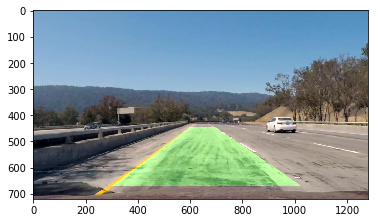

In [17]:
usePrevious = False
leftLine.detected = False
rightLine.detected = False

clip0 = VideoFileClip('project_video.mp4')
clip0.save_frame('test_t22.jpg', 22.2)

img = mpimg.imread('test_t22.jpg')
processed_img = process_image(img)
plt.figure()
plt.imshow(processed_img)

### Test on all other test images

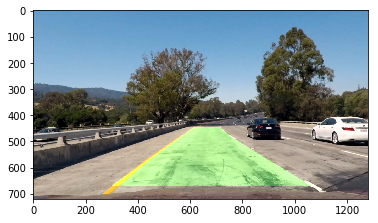

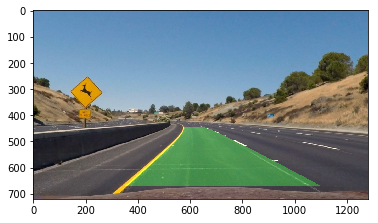

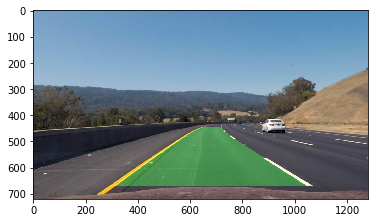

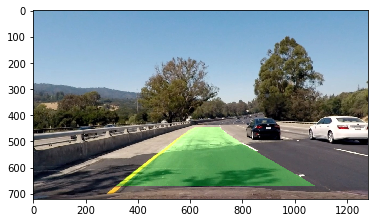

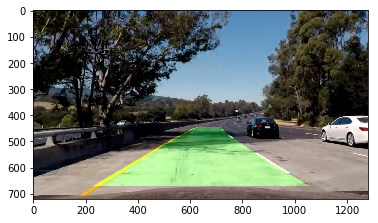

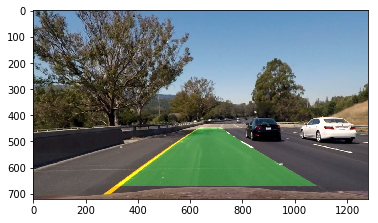

In [18]:
usePrevious = False
leftLine.detected = False
rightLine.detected = False
for i in range(1,7):
    img = mpimg.imread('test_images/test'+str(i)+'.jpg')
    processed_img = process_image(img)
    plt.figure()
    plt.imshow(processed_img)

In [19]:
usePrevious = True
leftLine.detected = False
rightLine.detected = False
#clip1 = VideoFileClip('project_video.mp4').subclip(21,24).fl_image(process_image)
clip1 = VideoFileClip('project_video.mp4').fl_image(process_image)
%time clip1.write_videofile('video.mp4', audio=False)

[MoviePy] >>>> Building video video.mp4
[MoviePy] Writing video video.mp4


 25%|██▍       | 311/1261 [00:59<03:10,  4.98it/s]

left curvature: 25548 m -0.0000
right curvature: 762 m -0.0002
left curvature: 1186779 m -0.0000
right curvature: 723 m -0.0002


 25%|██▍       | 314/1261 [01:00<03:15,  4.84it/s]

left curvature: 9081 m 0.0000
right curvature: 883 m -0.0001


 25%|██▍       | 315/1261 [01:00<03:19,  4.74it/s]

left curvature: 10329 m 0.0000
right curvature: 837 m -0.0001


 25%|██▌       | 321/1261 [01:01<03:00,  5.22it/s]

left curvature: 12605 m 0.0000
right curvature: 802 m -0.0002


 26%|██▌       | 322/1261 [01:02<03:23,  4.61it/s]

left curvature: 14318 m 0.0000
right curvature: 792 m -0.0002


 26%|██▌       | 323/1261 [01:02<03:22,  4.64it/s]

left curvature: 11474 m 0.0000
right curvature: 775 m -0.0002
left curvature: 28494 m 0.0000
right curvature: 940 m -0.0002


 26%|██▌       | 325/1261 [01:02<03:10,  4.92it/s]

left curvature: 11144 m 0.0000
right curvature: 918 m -0.0002


 26%|██▌       | 326/1261 [01:02<03:25,  4.54it/s]

left curvature: 17138 m 0.0000
right curvature: 1010 m -0.0002


 26%|██▌       | 327/1261 [01:03<03:43,  4.18it/s]

left curvature: 305215 m 0.0000
right curvature: 1286 m -0.0002
left curvature: 45752 m 0.0000
right curvature: 1503 m -0.0002


 26%|██▌       | 330/1261 [01:03<03:30,  4.42it/s]

left curvature: 629676 m 0.0000
right curvature: 4071 m -0.0001


 27%|██▋       | 342/1261 [01:06<03:04,  4.97it/s]

left curvature: 28009 m -0.0000
right curvature: 818 m -0.0001


 27%|██▋       | 344/1261 [01:06<03:01,  5.05it/s]

left curvature: 10070 m -0.0000
right curvature: 884 m -0.0001
left curvature: 158689 m -0.0000
right curvature: 767 m -0.0001


 27%|██▋       | 346/1261 [01:07<03:13,  4.73it/s]

left curvature: 77611 m -0.0000
right curvature: 799 m -0.0001


 28%|██▊       | 348/1261 [01:07<03:01,  5.02it/s]

left curvature: 10101 m 0.0000
right curvature: 775 m -0.0001


 29%|██▉       | 365/1261 [01:10<02:49,  5.30it/s]

left curvature: 1246 m 0.0001
right curvature: 19358 m -0.0000


 31%|███       | 390/1261 [01:15<03:06,  4.67it/s]

left curvature: 2625 m -0.0000
right curvature: 125501 m 0.0000


 32%|███▏      | 407/1261 [01:19<02:56,  4.83it/s]

left curvature: 47081 m -0.0000
right curvature: 2225 m -0.0000


 34%|███▎      | 423/1261 [01:22<02:53,  4.84it/s]

left curvature: 46142 m -0.0000
right curvature: 4433 m 0.0000


 35%|███▌      | 444/1261 [01:26<02:37,  5.19it/s]

left curvature: 2130 m 0.0001
right curvature: 31903 m -0.0000


 37%|███▋      | 464/1261 [01:30<02:41,  4.94it/s]

left curvature: 2824 m -0.0000
right curvature: 30242 m 0.0000


 38%|███▊      | 476/1261 [01:33<02:44,  4.77it/s]

left curvature: 13779 m 0.0000
right curvature: 1235 m -0.0001


 39%|███▊      | 487/1261 [01:35<02:34,  5.00it/s]

left curvature: 195615 m -0.0000
right curvature: 1280 m -0.0000
left curvature: 29795 m -0.0000
right curvature: 1417 m -0.0000


 39%|███▉      | 491/1261 [01:36<02:42,  4.74it/s]

left curvature: 7367 m -0.0000
right curvature: 131951 m -0.0000


 40%|████      | 506/1261 [01:39<02:39,  4.75it/s]

left curvature: 152991 m -0.0000
right curvature: 1274 m -0.0001


 41%|████      | 517/1261 [01:41<02:18,  5.38it/s]

left curvature: 19117 m 0.0000
right curvature: 694 m -0.0001


 41%|████      | 520/1261 [01:42<02:24,  5.11it/s]

left curvature: 6483 m 0.0000
right curvature: 470 m -0.0003


 43%|████▎     | 537/1261 [01:45<02:16,  5.31it/s]

left curvature: 5691 m 0.0000
right curvature: 542 m 0.0002


 43%|████▎     | 538/1261 [01:45<02:36,  4.62it/s]

left curvature: 18541 m 0.0000
right curvature: 600 m 0.0002


 43%|████▎     | 540/1261 [01:46<02:35,  4.62it/s]

left curvature: 12050 m 0.0000
right curvature: 486 m 0.0001


 43%|████▎     | 544/1261 [01:47<02:43,  4.39it/s]

left curvature: 10643 m -0.0000
right curvature: 491 m 0.0002


 44%|████▍     | 557/1261 [01:49<02:32,  4.61it/s]

left curvature: 4474 m -0.0000
right curvature: 402 m -0.0002
left curvature: 6848 m -0.0000
right curvature: 615 m -0.0002


 45%|████▍     | 567/1261 [01:52<02:30,  4.60it/s]

left curvature: 714 m -0.0002
right curvature: 28709 m -0.0001


 45%|████▌     | 569/1261 [01:52<02:37,  4.40it/s]

left curvature: 1761 m 0.0000
right curvature: 97140 m 0.0000


 46%|████▌     | 576/1261 [01:54<02:55,  3.89it/s]

left curvature: 25635 m -0.0000
right curvature: 877 m 0.0001


 46%|████▌     | 577/1261 [01:54<02:49,  4.03it/s]

left curvature: 11904 m -0.0000
right curvature: 947 m 0.0001


 46%|████▌     | 583/1261 [01:55<02:19,  4.87it/s]

left curvature: 13204 m 0.0001
right curvature: 1287 m 0.0000


 47%|████▋     | 591/1261 [01:57<02:20,  4.78it/s]

left curvature: 15988 m 0.0000
right curvature: 1548 m 0.0001


 77%|███████▋  | 965/1261 [03:13<00:56,  5.23it/s]

left curvature: 457 m 0.0002
right curvature: 9546 m 0.0001


 80%|████████  | 1011/1261 [03:23<00:56,  4.43it/s]

left curvature: 20286 m 0.0001
right curvature: 367 m 0.0003


 81%|████████  | 1019/1261 [03:24<00:57,  4.20it/s]

left curvature: 51309 m 0.0000
right curvature: 500 m 0.0002


 98%|█████████▊| 1231/1261 [04:10<00:06,  4.72it/s]

left curvature: 1347 m 0.0001
right curvature: 19720 m 0.0000


 99%|█████████▉| 1252/1261 [04:14<00:01,  5.04it/s]

left curvature: 23388 m -0.0000
right curvature: 1819 m -0.0000


 99%|█████████▉| 1254/1261 [04:14<00:01,  5.36it/s]

left curvature: 12222 m -0.0000
right curvature: 1168 m 0.0001


100%|█████████▉| 1260/1261 [04:16<00:00,  4.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video.mp4 

CPU times: user 2min 19s, sys: 1.36 s, total: 2min 20s
Wall time: 4min 18s
